In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import scipy
from scipy import special

In [4]:
from matplotlib import cm

In [5]:
w1_true, w2_true = 2,3

In [6]:
x = np.linspace(-1, 1, 20)

In [7]:
y = w1_true*x+w2_true+np.random.normal(scale=0.5, size=x.shape)

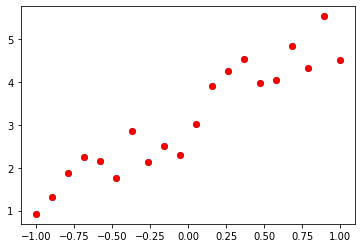

In [8]:
plt.plot(x, y, "o")
plt.plot(x[0:20], y[0:20], "o", color="red")


In [19]:
import numpyro as npyro
import jax
import jax.numpy as jnp
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [20]:
def model(x, y=None):
    
    w1 = npyro.sample("w1", dist.Normal(loc=0., scale=1.))
    w2 = npyro.sample("w2", dist.Normal(loc=0., scale=1.))
    
    mean = w1*x+w2
    
    sigma = npyro.sample("sigma", dist.Uniform(0., 1.))
    
    with npyro.plate("data", size=x.shape[0]):
        npyro.sample("obs", dist.Normal(mean, sigma), obs=y)
    
    return mean
    

In [21]:
from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, autoguide

In [22]:
guide = autoguide.AutoDiagonalNormal(model)

In [23]:
svi = SVI(model, guide, npyro.optim.Adam(0.03), TraceMeanField_ELBO())

In [24]:
params, losses = svi.run(jax.random.PRNGKey(15), num_steps=1000, x=x, y=y)

  0%|          | 0/1000 [00:00<?, ?it/s]/disk/users/nserra/numpyro/numpyro/infer/elbo.py:107: UserWarning: Failed to verify mean field restriction on the guide. To eliminate this warning, ensure model and guide sites occur in the same order.
Model sites:
  w1
  w2
  sigmaGuide sites:
  sigma
  w1
  w2
  warnings.warn("Failed to verify mean field restriction on the guide. "
100%|██████████| 1000/1000 [00:01<00:00, 577.74it/s, init loss: 268.4898, avg. loss [951-1000]: 23.0327]


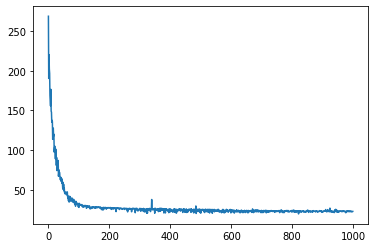

In [25]:
plt.plot(losses)

In [34]:
pred = Predictive(model=model, guide=guide, num_samples=3000, params=params, return_sites=["obs", "w1", "w2"])

In [35]:
xtest = np.linspace(-3., 3., 1000)

In [36]:
res = pred(jax.random.PRNGKey(54), xtest)

In [37]:
res["w1"].shape, res["w2"].shape

((3000,), (3000,))

Text(0, 0.5, '$w_2$')

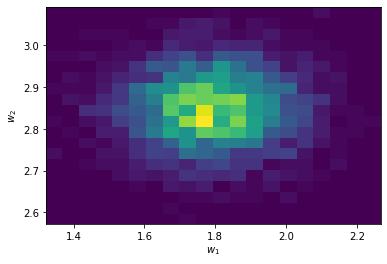

In [40]:
plt.hist2d(res["w1"], res["w2"], bins=20)
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")

In [35]:
line1 = res["w1"][0]*xtest+res["w2"][0]
line2 = res["w1"][10]*xtest+res["w2"][10]
line3 = res["w1"][20]*xtest+res["w2"][20]
line4 = res["w1"][30]*xtest+res["w2"][30]
line5 = res["w1"][40]*xtest+res["w2"][40]

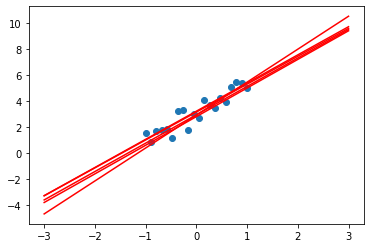

In [36]:
plt.plot(x, y, "o")
plt.plot(xtest, line1, color="red")
plt.plot(xtest, line2, color="red")
plt.plot(xtest, line3, color="red")
plt.plot(xtest, line4, color="red")
plt.plot(xtest, line5, color="red")

In [37]:
line_mean = np.mean(res["obs"], axis=0)
line_std = np.std(res["obs"], axis=0)


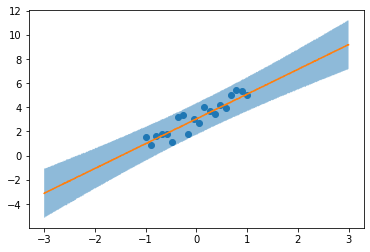

In [38]:
plt.plot(x, y, "o")
plt.plot(xtest, line_mean)
plt.fill_between(xtest, line_mean-2*line_std, line_mean+2*line_std, alpha=0.5)